In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import argparse
import imutils
from scipy import stats

# Initial Testing

This section covers basic image input and manipulation with CV2

In [2]:
img = cv2.imread('lines.png',2)
cimg = cv2.imread('redlines.png')

print(img.shape)
print(cimg.shape)

(773, 1000)
(773, 1000, 3)


In [3]:
#cv2.imshow('image',img)
#cv2.waitKey(0)

#cv2.imshow('cimage',cimg)
#cv2.waitKey(0)

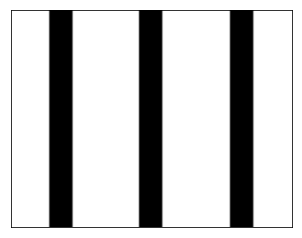

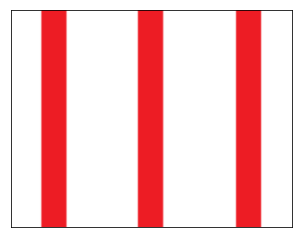

In [4]:
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic') #Look through different interpolations
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

plt.imshow(imutils.opencv2matplotlib(cimg),cmap = 'hsv', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])
plt.show()

In [5]:
##Test some accesses on the black and white image

imh = len(img)
blankp = 0
fillp = 0

for i in range(imh):
    #print(img[0][i])
    if(img[0][i] < 10):
        fillp = fillp + 1
    if(img[0][i] > 10):
        blankp = blankp + 1
        
print(fillp, blankp)

164 609


In [6]:
px = cimg[100,100]
print(px)

[255 255 255]


In [7]:
print(img.dtype)
print(cimg.dtype)

uint8
uint8


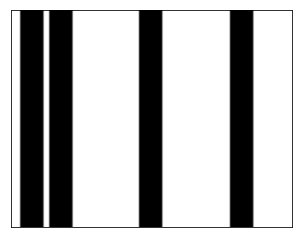

In [8]:
bar = img[0:773,113:220]
img[0:773,10:117] = bar

plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

In [9]:
cv2.destroyAllWindows()

In [10]:
slant = cv2.imread('slantedlines.png',2)

print(slant.shape)

(773, 1000)


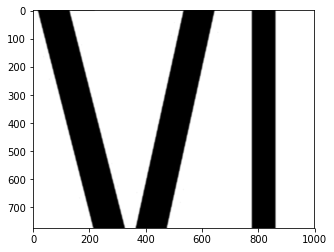

In [11]:
plt.imshow(slant, cmap = 'gray', interpolation = 'bicubic')
#plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

# Getwidths Definition and Member Functions

This section introduces all the functions necessary for getwidths 

In [3]:
def detectLTD(cur,nex,thresh=150):
    if( cur > nex ):
        if( cur-nex >= thresh):  #light to dark  
            return 1
    return 0

def detectDTL(cur,nex,thresh=150):
    if( cur < nex ):
        if( nex-cur >= thresh): #dark to light
            return 1
    return 0

In [4]:
def scoutDown(img,px,py,thresh=150):
    #first scout vertically from the initial pixel until a di is reached.
    if(detectLTD(img[px][py],img[px][py+1],thresh)):
        py+=1    
    
    cur = img[px][py] #get out initial value
    nex = img[px+1][py] #get the next value
    di = detectDTL(cur,nex,thresh) #check if the current pixel is immediatly on an edge
  
    #if not, loop to find the distance to the edge (and the px and py values of that point)
    #end result: px will be an edge row
    while di==0 and px < img.shape[0]-2:      
        px+=1 #incriment the current point
        cur = img[px][py] #set the current point
        nexv = img[px+1][py] #set the next point
        di = detectDTL(cur,nexv,thresh) #test to see if the current point is an edge
    
    return px

In [5]:
def scoutUp(img,px,py,thresh=150):
    #first scout vertically from the initial pixel until a di is reached.
    
    if(detectLTD(img[px][py],img[px][py+1],thresh)):
        py+=1
    
    cur = img[px][py] #get out initial value
    nex = img[px-1][py] #get the next value
    di = detectDTL(cur,nex,thresh) #check if the current pixel is immediatly on an edge
 
    #if not, loop to find the distance to the edge (and the px and py values of that point)
    #end result: px will be an edge row
    while di==0 and px > 2:       
        px-=1 #incriment the current point
        cur = img[px][py] #set the current point
        nexv = img[px-1][py] #set the next point
        di = detectDTL(cur,nexv,thresh) #test to see if the current point is an edge
    return px

In [6]:
def scoutRight(img,px,py,thresh=150):    
    cur = img[px][py] #get out initial value
    nex = img[px][py+1] #get the next value
    di = detectDTL(cur,nex,thresh) #check if the current pixel is immediatly on an edge
    #if not, loop to find the distance to the edge (and the px and py values of that point)
    #end result: px will be an edge row
    while di==0 and py < img.shape[1]-2:      
        py+=1 #incriment the current point
        cur = img[px][py] #set the current point
        nexv = img[px][py+1] #set the next point
        di = detectDTL(cur,nexv,thresh) #test to see if the current point is an edge
    
    return py

In [7]:
def scoutLeft(img,px,py,thresh=150):    
    cur = img[px][py] #get out initial value
    nex = img[px][py-1] #get the next value
    di = detectDTL(cur,nex,thresh) #check if the current pixel is immediatly on an edge
    #if not, loop to find the distance to the edge (and the px and py values of that point)
    #end result: px will be an edge row
    while di==0 and py > 0:      
        py-=1 #incriment the current point
        cur = img[px][py] #set the current point
        nexv = img[px][py-1] #set the next point
        di = detectDTL(cur,nexv,thresh) #test to see if the current point is an edge
    
    return py

In [8]:
def getwidths(img,row,thresh=150):

    imh = img.shape[1]
    di=0
    #row=100
    thresh=150
    distance = 100000;
    mindist = distance
    mindistA = []

    for col in range(imh-1):
        cur = img[row][col]
        nex = img[row][col+1]
        inc = detectLTD(cur,nex,thresh) #count horizontal intensity changes


        di+=inc #add intensity changes to count for total number of fibers
        if(inc): #if any change in intensity was detected-----------------------------------------------

            initialpix = [row,col]

            top = scoutUp(img,row,col,thresh) #give the topmost pixel distance from initial
            bottom = scoutDown(img,row,col,thresh) #give the bottommost pixel distance from initial

            #depending on if row-top or bottom-row is larger, use top or bottom as the seed
            #to begin searching right, incrimenting the seed either up or down until
            #the value returns to row. After each scoutRight, take the seed and the returned
            #py value from the function to calculate the distance from the initial pixel.

            if((row-top)>(bottom-row)):
                start = top
                mindist = row-top
                direction = 1
            else:
                start = bottom
                mindist = bottom - row
                direction = -1

            while start != initialpix[0]:
                rightmost = scoutRight(img,start,col,thresh)
                distance = np.sqrt((start-initialpix[0])**2+(rightmost-initialpix[1])**2)
                theta = np.arctan((rightmost-initialpix[1])/(start-initialpix[0]))
                if distance < mindist and distance != 0:
                    mindist = distance + 1/(np.sin(theta))

                start = start + direction

            mindistA.append(mindist)
            #-------------------------------------------------------------------------------------------
        distance = 100000
        mindist = distance

    print(di)
    print(mindistA)


    #plt.figure(figsize=[20,10])
    #plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
    #plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    #plt.show()
    
    return mindistA

# ------------------------------------------------------------

# Getwidths Examples and Testing

(824, 878)


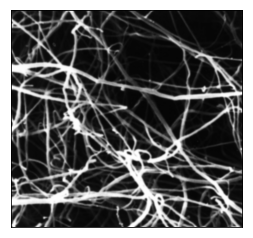

33

In [12]:
fibers = cv2.imread('fibers.png',2)

print(fibers.shape)
plt.imshow(fibers, cmap='gray',interpolation = 'bicubic') #Look through different interpolations
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

fibers[100,100]

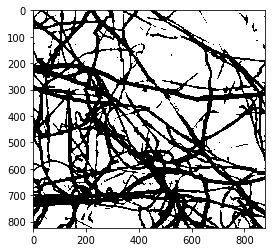

In [19]:
ret,BF = cv2.threshold(fibers,50,255,cv2.THRESH_BINARY_INV)

plt.imshow(BF,cmap='gray')
#plt.xticks([]),plt.yticks([])
    
plt.show()

In [20]:
np.average(getwidths(BF,230))

9
[13.045060793691654, 18.384776310850235, 2.82842712474619, 9.070039966835868, 11.543396380615196, -3.552713678800501e-15, 8.081220356417687, 17.528548142958105, 12.049484746022467]


10.281217091348601

array([255, 255, 255], dtype=uint8)

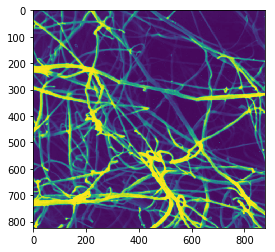

In [21]:
bgr = cv2.cvtColor(BF,cv2.COLOR_GRAY2BGR)
plt.imshow(bgr)
plt.imshow(fibers)
bgr[100,100]

(773, 1000)


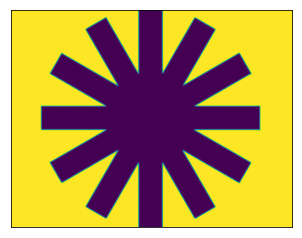

In [22]:
lM = cv2.imread('linesMatrix.png',2)

print(lM.shape)
plt.imshow(lM, interpolation = 'bicubic') #Look through different interpolations
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

In [23]:
np.average(getwidths(lM,400))

1
[48.3735464897913]


48.3735464897913

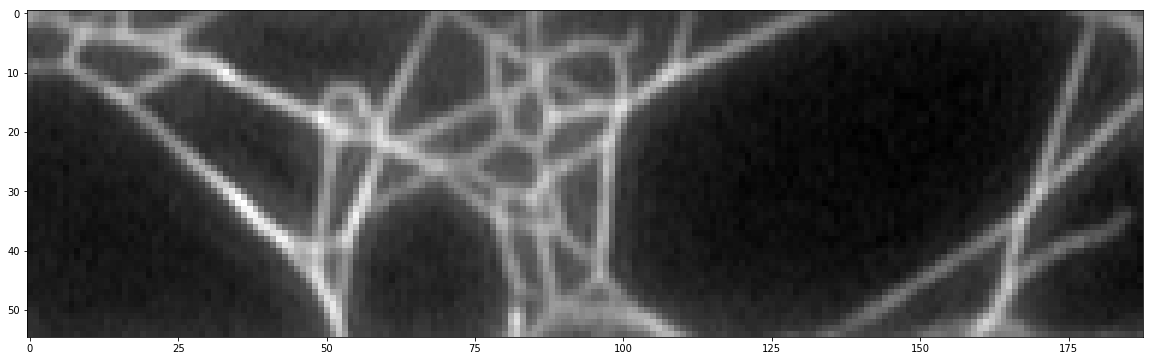

In [24]:
ecu = cv2.imread("mainfibers.png",2)
#ecu = ecu[:,500:]
plt.figure(figsize=[20,10])
plt.imshow(ecu,cmap='gray')

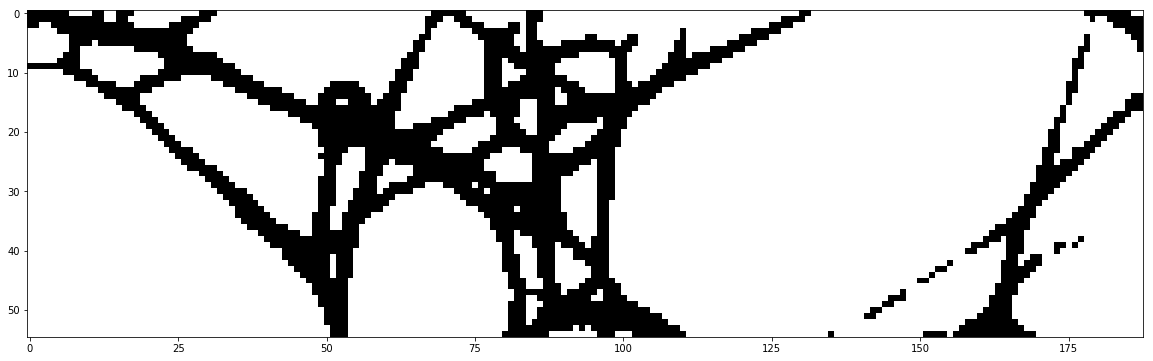

In [25]:
ret2,BECU = cv2.threshold(ecu,93,255,cv2.THRESH_BINARY_INV)
plt.figure(figsize=[20,10])
plt.imshow(BECU,cmap='gray')

In [26]:
print(np.average(getwidths(BECU,9)))
print(np.average(getwidths(BECU,21)))
print(np.average(getwidths(BECU,34)))
print(np.average(getwidths(BECU,49)))

7
[4.242640687119286, 3.3541019662496847, 4.216370213557839, 3, 3.3541019662496847, 3, 2.8284271247461903]
3.4279488511318124
6
[2, 4.47213595499958, 2, 3, 3.3541019662496847, 2]
2.8043729868748777
6
[4, 4.216370213557839, 5.153882032022076, 3, 1.4142135623730951, 4.216370213557839]
3.6668060035851417
5
[3.16227766016838, 4.216370213557839, 2.23606797749979, 0, 4]
2.722943170245202


In [27]:
#for i in np.arange(2,50):
#    print(i,np.std(getwidths(BECU,i)))
print(np.std(getwidths(BECU,9)))
print(np.std(getwidths(BECU,21)))
print(np.std(getwidths(BECU,34)))
print(np.std(getwidths(BECU,49)))
    

7
[4.242640687119286, 3.3541019662496847, 4.216370213557839, 3, 3.3541019662496847, 3, 2.8284271247461903]
0.5374469403640052
6
[2, 4.47213595499958, 2, 3, 3.3541019662496847, 2]
0.9185997408119669
6
[4, 4.216370213557839, 5.153882032022076, 3, 1.4142135623730951, 4.216370213557839]
1.1863991703179932
5
[3.16227766016838, 4.216370213557839, 2.23606797749979, 0, 4]
1.5300771376537088


# ---------------------------------------------------------

# Thinning Function Definition and Branchpoint Location

Thinning Algorithm

Phase 0:
    scan through the image and create a list of all border pixels that satisfy the condition:
        When detecting a LTD, scout right until a DTL. Subtract the pixel locations--if less than           three pixels, add that to the 2 WIDE list but NOT border list. Add ALL DTL pixels to the           list.
Phase 1:
    loop through border array. Delete any pixels that have exactly 3 neighbors.
    
Phase 2:
    loop through the border array. Delete any pixels that have exactly 4 neighbors.
    
Phase 3:
    loop through the border array. Delete pixels with 5 neighbors
    
Phase 4:
    loop through array. Delete pixels with 6 neighbors

Phase 5:
    loop through array. Delete any with 7 neighbors.

Phase 6:
    Is the size of the list now less than the size of the list at Phase 1? If so, clear
    border array and repeat.
    If not, go to FINAL.

FINAL:
    Go through 2 WIDE list. This list should contain a list of pixels that begin 2 WIDE rows.
    Delete all pixels.

In [10]:
#Lookup arrays
A1 = [7,14,28,56,112,131,193,224]
A2 = [7,14,15,28,30,31,56,60,62,112,120,131,135,193,195,224,225,240]
A3 = [7,14,15,28,30,31,56,60,62,112,120,124,131,135,143,193,195,199,224,225,227,240,241,248]
A4 = [7,14,15,28,30,31,56,60,62,112,120,124,131,135,143,193,195,199,224,225,227,240,241,248,63,126,159,199,207,231,243,249,252]
A5 = [7,14,15,28,30,31,56,60,62,112,120,124,131,135,143,193,195,199,224,225,227,240,241,248,63,126,159,199,207,231,243,249,252,239,251,254]
A6 = [3,6,7,12,14,15,24,28,30,31,48,56,60,62,63,96,112,120,124,126,127,129,131,135,143,159,191,192,193,195,199,207,223,224,225,227,231,239,240,241,243,247,248,249,251,252,253,254]
A = [A1,A2,A3,A4,A5,A6]

In [11]:
def thin(image):
    nrows = image.shape[0] #number of rows in the image
    ncols = image.shape[1] #number of columns in the image

    end=0
    iteration = 0
    twoWide = []
    twoWideMarked = []
    while(end == 0):
        
        #create / clear the borders array
        #twoWide does not get cleared after every round. It accumulates 2 wide areas for later
        #destruction
        borders = []

        #PHASE0-------------------------------------------------------------------------------
        #Create the border and twoWide arrays
        for row in range(nrows-1): #outside loop should be over the number of rows in the image
            for col in range(ncols-2): #inside loop over columns
                #define my current and next pixels
                cur = col
                nex = col+1
                
                #upon LTD, scout right. If the line is 2 pixels wide, add it to twoWide
                #otherwise add it to borders
                if detectLTD(image[row][cur],image[row][nex]):
                    rightwidth = scoutRight(image,row,cur+1)
                    if (rightwidth-col)==2:
                        twoWide.append([row,col+1])
                    elif(rightwidth-col)>=3:
                        borders.append([row,col+1])
                #add all LTDs to borders
                if detectDTL(image[row][cur],image[row][nex]):
                    leftwidth = scoutLeft(image,row,cur)
                    if(col-leftwidth-1)>=3:
                        borders.append([row,col])
        #-------------------------------------------------------------------------------------

        #store the length of borders
        blen = len(borders)
        
        #PHASE2-5-----------------------------------------------------------------------------
        for phase in range(5):
            i=0
            limit = len(borders)
            while i < limit-1:
                weight = getneighborhoodweight(image,borders[i][0],borders[i][1])
                if weight in A[phase]:
                    image[borders[i][0],borders[i][1]] = 255
                    borders = [x for x in borders if x != borders[i]]
                i = i+1
                limit= len(borders)
        #-------------------------------------------------------------------------------------

        #print("\n Pixels deleted: ",blen-len(borders))
        #PHASE6-------------------------------------------------------------------------------
        if(blen == len(borders)):
            end = 1
        iteration = iteration + 1
        #print(iteration)
        borders.clear()
        #-------------------------------------------------------------------------------------
    
    #FINAL------------------------------------------------------------------------------------
    limit = len(twoWide)
    i = 0
    while i < limit:
        if(image[twoWide[i][0]-1,twoWide[i][1]] == 0):
            twoWideMarked.append([twoWide[i][0],twoWide[i][1]])
#            image[twoWide[i][0],twoWide[i][1]] = 255
            twoWide = [x for x in twoWide if x != twoWide[i]]
        else:
            twoWide = [x for x in twoWide if x != twoWide[i]]
        limit = len(twoWide)
        i=0
    
    i = 0
    limit = len(twoWideMarked)
    while i < limit:
        image[twoWideMarked[i][0],twoWideMarked[i][1]] = 255
        twoWideMarked = [x for x in twoWideMarked if x != twoWideMarked[i]]
        limit = len(twoWideMarked)
        i = 0

In [12]:
def getneighborhood(image,row,col,thresh=150):
    neighbors = 0
    if(row >= 1 and row <= (image.shape[0]-2) and col >= 1 and col <= (image.shape[1]-2)):
        if(image[row-1][col-1]<=thresh):
            neighbors = neighbors+1
        if(image[row-1][col]<=thresh):
            neighbors = neighbors+1
        if(image[row-1][col+1]<=thresh):
            neighbors = neighbors+1
        if(image[row][col-1]<=thresh):
            neighbors = neighbors+1
        if(image[row][col+1]<=thresh):
            neighbors = neighbors+1
        if(image[row+1][col-1]<=thresh):
            neighbors = neighbors+1
        if(image[row+1][col]<=thresh):
            neighbors = neighbors+1
        if(image[row+1][col+1]<=thresh):
            neighbors = neighbors+1
    return neighbors

In [13]:
def getneighborhoodweight(image,row,col,thresh=150):
    neighbors = 0
    if(row >= 1 and row <= (image.shape[0]-2) and col >= 1 and col <= (image.shape[1]-2)):
        if(image[row-1][col-1]<=thresh):
            neighbors = neighbors+128
        if(image[row-1][col]<=thresh):
            neighbors = neighbors+1
        if(image[row-1][col+1]<=thresh):
            neighbors = neighbors+2
        if(image[row][col-1]<=thresh):
            neighbors = neighbors+64
        if(image[row][col+1]<=thresh):
            neighbors = neighbors+4
        if(image[row+1][col-1]<=thresh):
            neighbors = neighbors+32
        if(image[row+1][col]<=thresh):
            neighbors = neighbors+16
        if(image[row+1][col+1]<=thresh):
            neighbors = neighbors+8
    return neighbors

In [14]:
def skeletonize(image):
    thin(image)
    rimage = imutils.rotate_bound(image,90)
    thin(rimage)
    image = imutils.rotate_bound(rimage,-90)

In [15]:
def findBranchpoints(image):
    nrows = image.shape[0] #number of rows in the image
    ncols = image.shape[1] #number of columns in the image
    
    ibranch = []
    fbranch = []
    for row in range(nrows-1): #outside loop should be over the number of rows in the image
        for col in range(ncols-2): #inside loop over columns
            if row != 0 and image[row][col]==0:
                if(getneighborhood(image,row,col)>=4):
                    ibranch.append([row,col])            
    
    print(ibranch)
    
    i = 0
    j=0
    #print(ibranch[j])
    #print(ibranch[j][0])
    limit = len(ibranch)
    while i < limit:
        while j < limit:
            distance = np.sqrt(((ibranch[j][0]-ibranch[i][0])**2)+(ibranch[j][1]-ibranch[i][1])**2)
            if( distance <= 6 and i != j):
                #ibranch = [x for x in ibranch if x != j]
                ibranch.pop(j)
                j = j
                limit = len(ibranch)
    #            print(distance)
            else:
                j=j+1
        j=0
        i=i+1
    print(ibranch)
    return ibranch

# ---------------------------------------------------

# Thinning Function Examples

In [16]:
small = cv2.imread("mainfibers.png",2)

ret3,small = cv2.threshold(ecu,93,255,cv2.THRESH_BINARY_INV)
plt.figure(figsize=[20,10])
plt.imshow(small,cmap='gray')

NameError: name 'ecu' is not defined

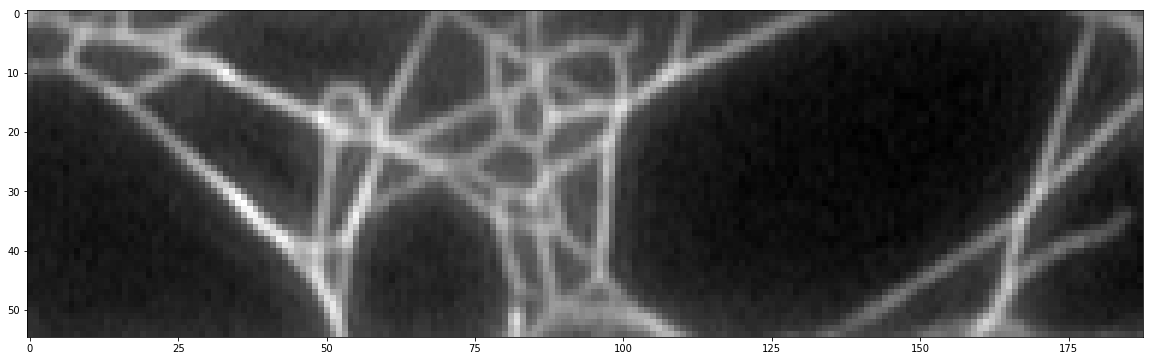

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

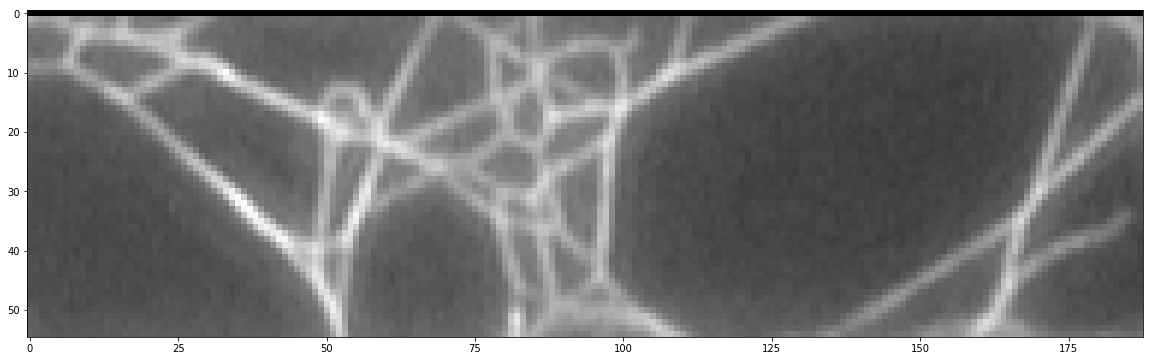

In [17]:
plt.figure(figsize=[20,10])
plt.imshow(small,cmap='gray')

thin(small)
plt.figure(figsize=[20,10])
#plt.imshow(small,cmap='gray')

small = imutils.rotate_bound(small,90)
plt.figure(figsize=[20,10])
#plt.imshow(small,cmap='gray')

thin(small)
plt.figure(figsize=[20,10])
#plt.imshow(small,cmap='gray')

small = imutils.rotate_bound(small,-90)
plt.figure(figsize=[20,10])
plt.imshow(small,cmap='gray')

In [36]:
small[0,:] = 255

print(len(findBranchpoints(small)))

[[1, 1], [2, 1], [2, 11], [2, 12], [2, 75], [3, 12], [3, 67], [4, 19], [4, 66], [5, 66], [5, 95], [6, 8], [6, 23], [6, 86], [6, 87], [6, 99], [7, 85], [7, 86], [7, 177], [8, 27], [8, 28], [8, 79], [8, 111], [9, 7], [9, 28], [9, 110], [11, 34], [12, 12], [12, 36], [13, 54], [13, 80], [13, 84], [13, 85], [13, 92], [13, 101], [13, 102], [14, 17], [14, 41], [14, 53], [14, 54], [14, 80], [14, 93], [14, 94], [15, 43], [15, 50], [15, 51], [15, 54], [15, 55], [15, 79], [15, 94], [16, 53], [16, 54], [16, 89], [16, 93], [16, 94], [17, 90], [19, 56], [19, 173], [20, 57], [20, 58], [20, 59], [21, 58], [21, 60], [21, 83], [21, 84], [22, 61], [23, 61], [23, 62], [23, 95], [23, 96], [25, 70], [25, 91], [25, 172], [26, 173], [27, 71], [27, 72], [27, 174], [28, 73], [28, 74], [28, 173], [29, 73], [29, 76], [29, 77], [29, 172], [30, 75], [30, 76], [30, 78], [31, 58], [31, 59], [31, 77], [32, 80], [32, 81], [32, 170], [33, 80], [33, 83], [33, 84], [34, 37], [34, 38], [34, 81], [34, 82], [34, 83], [35, 82

In [37]:
background = cv2.imread("mainfibers-threshhold.png",3)
overlay = cv2.cvtColor(small,cv2.COLOR_GRAY2BGR)
overlay[np.where((overlay == [0,0,0] ).all(axis = 2))] = [255,0,0]

added_image = cv2.addWeighted(background,0.9,overlay,0.8,0)
plt.figure(figsize=[20,10])
plt.imshow(added_image,cmap="gray")

error: OpenCV(3.4.3) /io/opencv/modules/core/src/arithm.cpp:659: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'arithm_op'


In [ ]:
branchpoints = findBranchpoints(small)
branchmap = cv2.cvtColor(small,cv2.COLOR_GRAY2BGR)
print(len(branchpoints))
for i in range(len(branchpoints)):
    branchmap[ branchpoints[i][0] , branchpoints[i][1] ]= [255,0,0]

plt.figure(figsize=[20,10])
plt.imshow(branchmap,cmap="gray")

In [ ]:
small2 = cv2.imread("mainfibers-skeletonJ.jpg",2)
#ret4,small2 = cv2.threshold(small2,93,255,cv2.THRESH_BINARY_INV)
#plt.figure()
#plt.imshow(small2)
#skeletonize(small2)

branchpoints = findBranchpoints(small2)
branchmap = cv2.cvtColor(small2,cv2.COLOR_GRAY2BGR)
print(len(branchpoints))
for i in range(len(branchpoints)):
    branchmap[ branchpoints[i][0] , branchpoints[i][1] ]= [255,0,0]

plt.figure(figsize=[20,10])
plt.imshow(branchmap,cmap="gray")

In [ ]:
#plt.imshow(small2)

In [38]:
background2 = cv2.cvtColor(small2,cv2.COLOR_GRAY2BGR)

added_image2 = cv2.addWeighted(background2,0.9,overlay,0.8,0)
plt.figure(figsize=[20,10])
plt.imshow(added_image2,cmap="gray")

NameError: name 'small2' is not defined

# Large Image Thin Test

In [40]:
# plt.figure(figsize=[20,10])
# plt.imshow(BF,cmap='gray')

# thin(BF)
# plt.figure(figsize=[20,10])
# #plt.imshow(BF,cmap='gray')

# BF = imutils.rotate_bound(BF,90)
# plt.figure(figsize=[20,10])
# #plt.imshow(BF,cmap='gray')

# thin(BF)
# plt.figure(figsize=[20,10])
# #plt.imshow(BF,cmap='gray')

# BF = imutils.rotate_bound(BF,-90)
# plt.figure(figsize=[20,10])
# #plt.imshow(BF,cmap='gray')

# Small Composite Example

(25, 25)


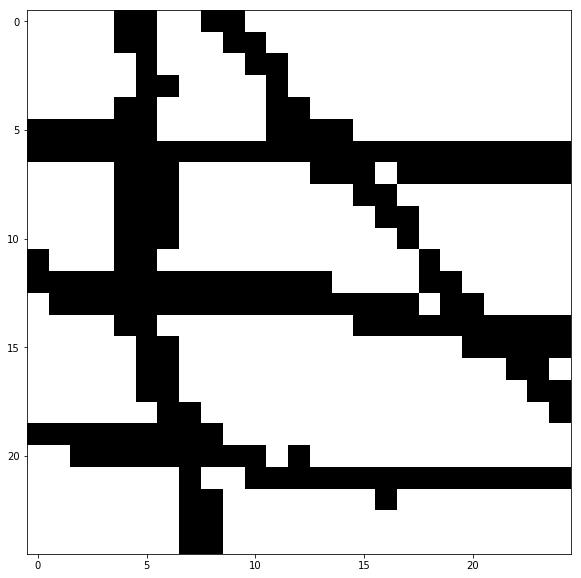

In [13]:
tfbtf = cv2.imread("tfbtf.png",2)

plt.figure(figsize=[20,10])
plt.imshow(tfbtf,cmap='gray')
print(tfbtf.shape)

In [14]:
plt.figure(figsize=[20,10])
#plt.imshow(tfbtf,cmap='gray')

thin(tfbtf)
plt.figure(figsize=[20,10])
#plt.imshow(tfbtf,cmap='gray')

tfbtf = imutils.rotate_bound(tfbtf,90)
plt.figure(figsize=[20,10])
#plt.imshow(tfbtf,cmap='gray')

thin(tfbtf)
plt.figure(figsize=[20,10])
#plt.imshow(tfbtf,cmap='gray')

tfbtf = imutils.rotate_bound(tfbtf,-90)
plt.figure(figsize=[20,10])
plt.imshow(tfbtf,cmap='gray')

NameError: name 'thin' is not defined

<Figure size 1440x720 with 0 Axes>

In [ ]:
tfbtf[0,:] = 255

print(len(findBranchpoints(tfbtf)))

In [ ]:
background = cv2.imread("tfbtf.png",3)
overlay = cv2.cvtColor(tfbtf,cv2.COLOR_GRAY2BGR)
overlay[np.where((overlay == [0,0,0] ).all(axis = 2))] = [255,0,0]

added_image = cv2.addWeighted(background,0.9,overlay,0.8,0)
plt.figure(figsize=[20,10])
plt.imshow(added_image,cmap="gray")

In [15]:
branchpoints = findBranchpoints(tfbtf)
branchmap = cv2.cvtColor(tfbtf,cv2.COLOR_GRAY2BGR)
for i in range(len(branchpoints)):
    branchmap[ branchpoints[i][0] , branchpoints[i][1] ]= [255,0,0]

plt.figure(figsize=[20,10])
plt.imshow(branchmap,cmap="gray")

NameError: name 'findBranchpoints' is not defined

In [16]:
tfbtf = cv2.imread("tfbtf.png",2)
print(np.average(getwidths(tfbtf,5)))
print(np.average(getwidths(tfbtf,10)))
print(np.average(getwidths(tfbtf,15)))
print(np.average(getwidths(tfbtf,20)))

NameError: name 'getwidths' is not defined

In [17]:
print(stats.sem(getwidths(tfbtf,5)))
print(stats.sem(getwidths(tfbtf,10)))
print(stats.sem(getwidths(tfbtf,15)))
print(stats.sem(getwidths(tfbtf,20)))

NameError: name 'getwidths' is not defined

# Gradient Stuff

<class 'numpy.ndarray'> 625


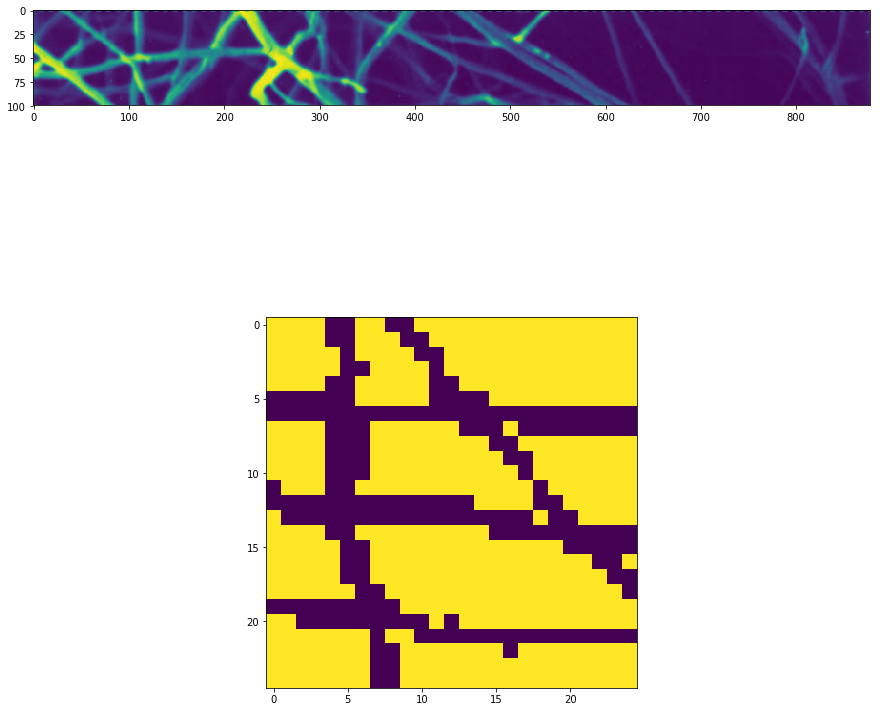

In [65]:
grad = cv2.imread("gradienttest.png",2)

plt.figure(figsize=[15,15])
plt.subplot(2,1,1),plt.imshow(fibers[:100][:100])
plt.subplot(2,1,2),plt.imshow(tfbtf)
print(type(grad),tfbtf.size)

(<matplotlib.axes._subplots.AxesSubplot at 0x7fd6c517e630>,
 <matplotlib.image.AxesImage at 0x7fd6c511c2b0>)

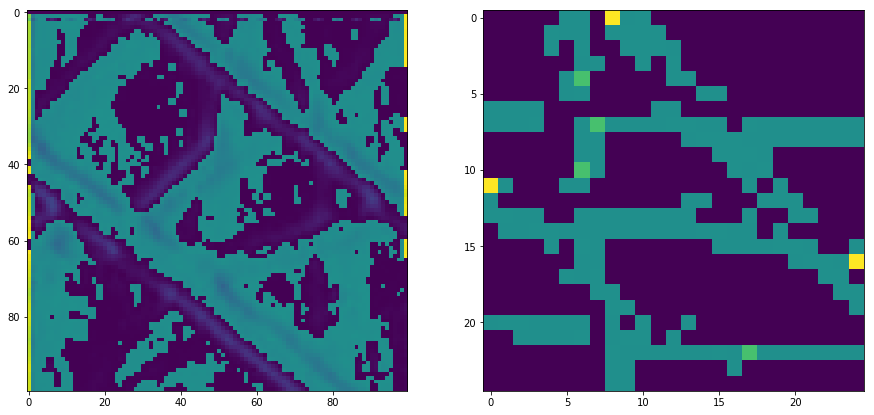

In [68]:
num=100
vgrad = np.gradient(fibers[0:num,0:num])
vt = np.gradient(tfbtf)
mag2 = np.sqrt(vt[0]**2 + vt[1]**2)
mag = np.sqrt(vgrad[0]**2 + vgrad[1]**2)

plt.figure(figsize=[15,15])
plt.subplot(1,2,1),plt.imshow(vgrad[1])
plt.subplot(1,2,2),plt.imshow(mag2)

In [20]:
import scipy

In [21]:
x, y = range(0, 100), range(0,100)
x1,y1 = range(0,25), range(0,25)
xi, yi = np.meshgrid(x, y)
x1i,y1i = np.meshgrid(x1,y1)


#rbf = scipy.interpolate.Rbf(xi, yi, vgrad[0])
#rbf2 = scipy.interpolate.Rbf(xi, yi, vgrad[0])

#plt.imshow(grad, vmin = np.amin(vgrad[0]), vmax=np.amax(vgrad[0]))
#plt.colorbar()
#plt.show()  

(<matplotlib.axes._subplots.AxesSubplot at 0x7fd6e210f630>,
 <matplotlib.streamplot.StreamplotSet at 0x7fd6dcd3eb00>)

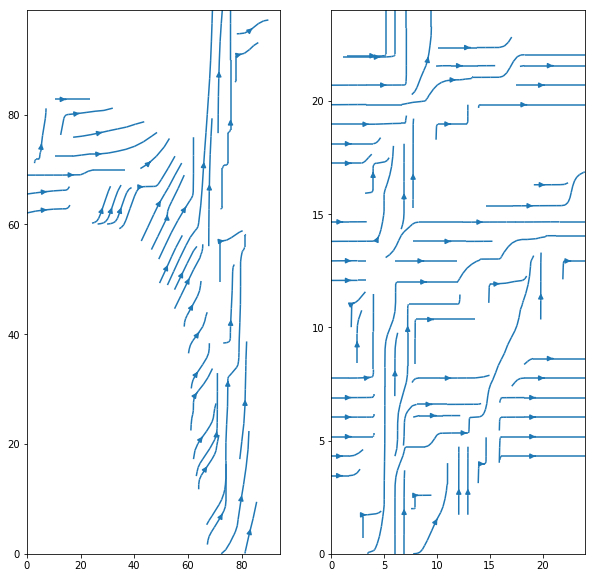

In [22]:
plt.figure(figsize=[10,10])
plt.subplot(1,2,1),plt.streamplot(xi, yi, vgrad[0], vgrad[1])
plt.subplot(1,2,2),plt.streamplot(x1i, y1i, vt[0], vt[1])

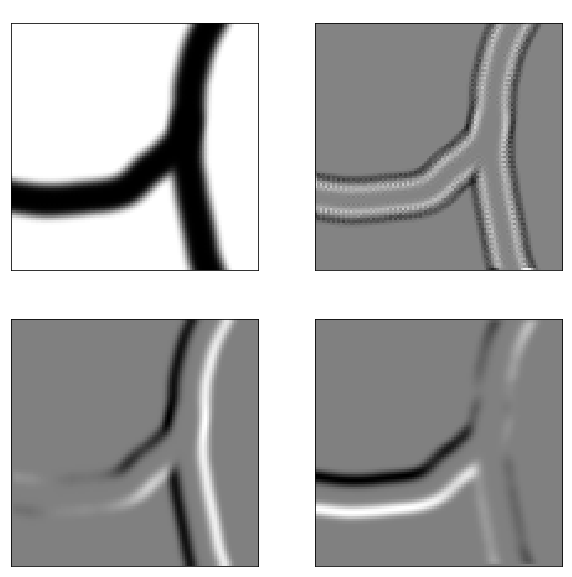

In [23]:
laplacian = cv2.Laplacian(grad,cv2.CV_64F)
sobelx = cv2.Sobel(grad,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(grad,cv2.CV_64F,0,1,ksize=5)
plt.figure(figsize=[10,10])

plt.subplot(2,2,1),plt.imshow(grad,cmap = 'gray')
plt.title('Original',color="white"), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian',color="white"), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X',color="white"), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y',color="white"), plt.xticks([]), plt.yticks([])

plt.show()

In [24]:
mirror = np.zeros(laplacian.shape)

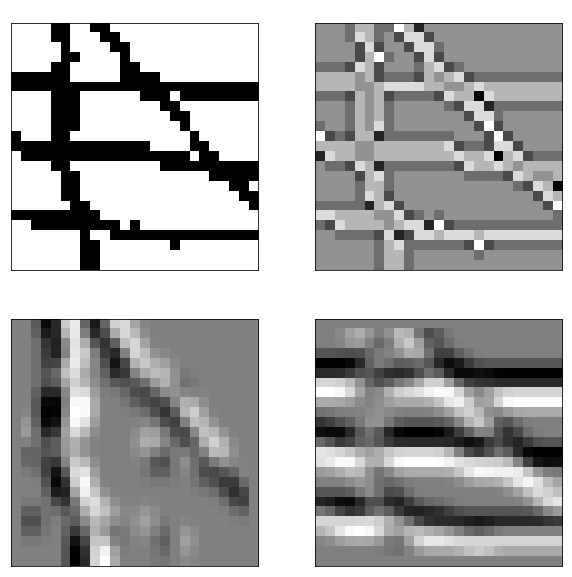

In [25]:
laplacian = cv2.Laplacian(tfbtf,cv2.CV_64F)
sobelx = cv2.Sobel(tfbtf,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(tfbtf,cv2.CV_64F,0,1,ksize=5)
plt.figure(figsize=[10,10])

plt.subplot(2,2,1),plt.imshow(tfbtf,cmap = 'gray')
plt.title('Original',color="white"), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian',color="white"), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X',color="white"), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y',color="white"), plt.xticks([]), plt.yticks([])

plt.show()

(<matplotlib.axes._subplots.AxesSubplot at 0x7fd6dc9fb0f0>,
 <matplotlib.image.AxesImage at 0x7fd6dca23780>)

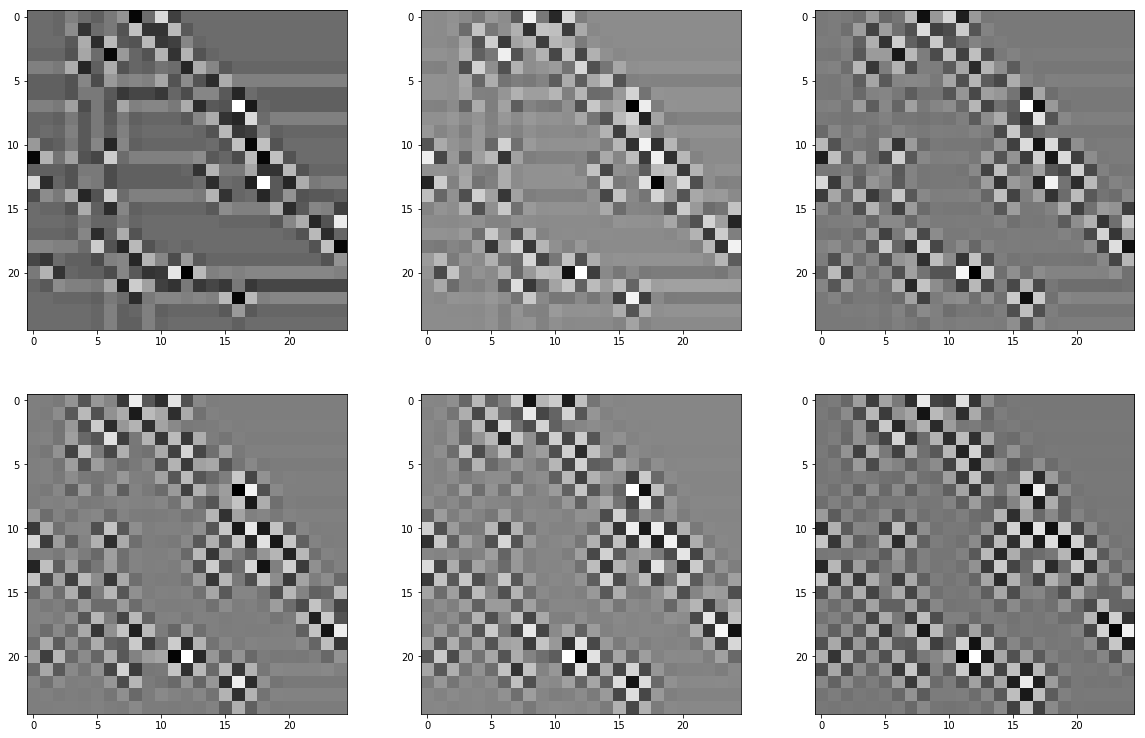

In [26]:
plt.figure(figsize=[20,20])
lap2 = cv2.Laplacian(laplacian,cv2.CV_64F)
plt.subplot(3,3,1),plt.imshow(lap2,cmap="gray")
lap3 = cv2.Laplacian(lap2,cv2.CV_64F)
plt.subplot(3,3,2),plt.imshow(lap3,cmap="gray")
lap4 = cv2.Laplacian(lap3,cv2.CV_64F)
plt.subplot(3,3,3),plt.imshow(lap4,cmap="gray")
lap5 = cv2.Laplacian(lap4,cv2.CV_64F)
plt.subplot(3,3,4),plt.imshow(lap5,cmap="gray")
lap6 = cv2.Laplacian(lap5,cv2.CV_64F)
plt.subplot(3,3,5),plt.imshow(lap6,cmap="gray")
lap7 = cv2.Laplacian(lap6,cv2.CV_64F)
plt.subplot(3,3,6),plt.imshow(lap7,cmap="gray")

In [27]:
from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering

In [28]:
mask = grad.astype(bool)
graph = image.img_to_graph(grad, mask=mask)

mask2 = tfbtf.astype(bool)
graph2 = image.img_to_graph(tfbtf, mask=mask2)

# Take a decreasing function of the gradient: we take it weakly
# dependant from the gradient the segmentation is close to a voronoi
graph.data = np.exp(-graph.data / graph.data.std())
graph2.data = np.exp(-graph2.data / graph2.data.std())
# Force the solver to be arpack, since amg is numerically
# unstable on this example

/home/soundofives/programs/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


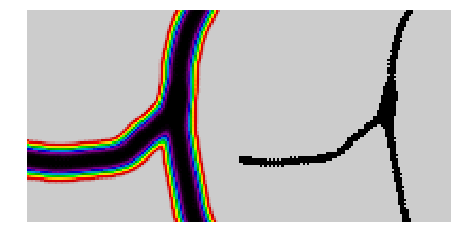

In [29]:
labels = spectral_clustering(graph, n_clusters=1)
label_im = -np.ones(mask.shape)
label_im[mask] = labels

plt.figure(figsize=(6, 3))
plt.subplot(121)
plt.imshow(grad, cmap=plt.cm.nipy_spectral, interpolation='nearest')
plt.axis('off')
plt.subplot(122)
plt.imshow(label_im, cmap=plt.cm.nipy_spectral, interpolation='nearest')
plt.axis('off')

plt.subplots_adjust(wspace=0, hspace=0., top=0.99, bottom=0.01, left=0.01, right=0.99)
plt.show()

/home/soundofives/programs/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


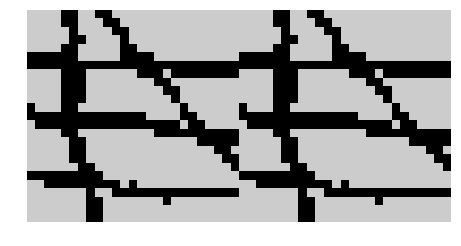

In [30]:
labels2 = spectral_clustering(graph2, n_clusters=1)
label_im2 = -np.ones(mask2.shape)
label_im2[mask2] = labels2

plt.figure(figsize=(6, 3))
plt.subplot(121)
plt.imshow(tfbtf, cmap=plt.cm.nipy_spectral, interpolation='nearest')
plt.axis('off')
plt.subplot(122)
plt.imshow(label_im2, cmap=plt.cm.nipy_spectral, interpolation='nearest')
plt.axis('off')

plt.subplots_adjust(wspace=0, hspace=0., top=0.99, bottom=0.01, left=0.01, right=0.99)
plt.show()

# ------------------------------------------------------------------------------------

In [31]:
# fig = plt.figure()
# ax = fig.gca(projection='3D')
# surf = ax.plot_surface(xi, yi, vgrad)
# plt.show()

# Custom Gradient Extraction

In [32]:
import pprint as pp

In [33]:
tfbtf.shape

(25, 25)

In [34]:
grad = np.zeros((3,3))
grad[0,0] = 1

In [77]:
def getPixGrad(img,r,c):
    rows = img.shape[0]
    cols = img.shape[1]
    grad = np.zeros((3,3))
    if r < rows-1 and r > 0 and c < cols-1 and c > 0:
        grad[0,0] = int(img[r,c]) - int(img[r-1,c-1])
        grad[0,1] = int(img[r,c]) - int(img[r-1,c])
        grad[0,2] = int(img[r,c]) - int(img[r-1,c+1])
        grad[1,0] = int(img[r,c]) - int(img[r,c-1])
        grad[1,1] = int(img[r,c]) - int(img[r,c])
        grad[1,2] = int(img[r,c]) - int(img[r,c+1])
        grad[2,0] = int(img[r,c]) - int(img[r+1,c-1])
        grad[2,1] = int(img[r,c]) - int(img[r+1,c])
        grad[2,2] = int(img[r,c]) - int(img[r+1,c+1])
    return grad

In [109]:
# Goal: for each pixel exclusevly
# inside the border pixels, create a 3x3 array of gradient values with pixels corresponding to the 3x3 position around the active pixel
#pp.pprint(tfbtf)
def getImgGrad(img):
    gradient = np.ndarray([img.shape[0],img.shape[1],3,3])
    avgG = np.ndarray([img.shape[0],img.shape[1]])
    rows = img.shape[0]
    cols = img.shape[1]
    for r in range(0,img.shape[0]):
        for c in range(0,img.shape[1]):
            #now we are iterating through all row-combo pairs.
            #print(getPixGrad(img,r,c))
            gradient[r,c] = getPixGrad(img,r,c)
            avgG[r,c] = gradient[r,c].sum()
    return gradient,avgG

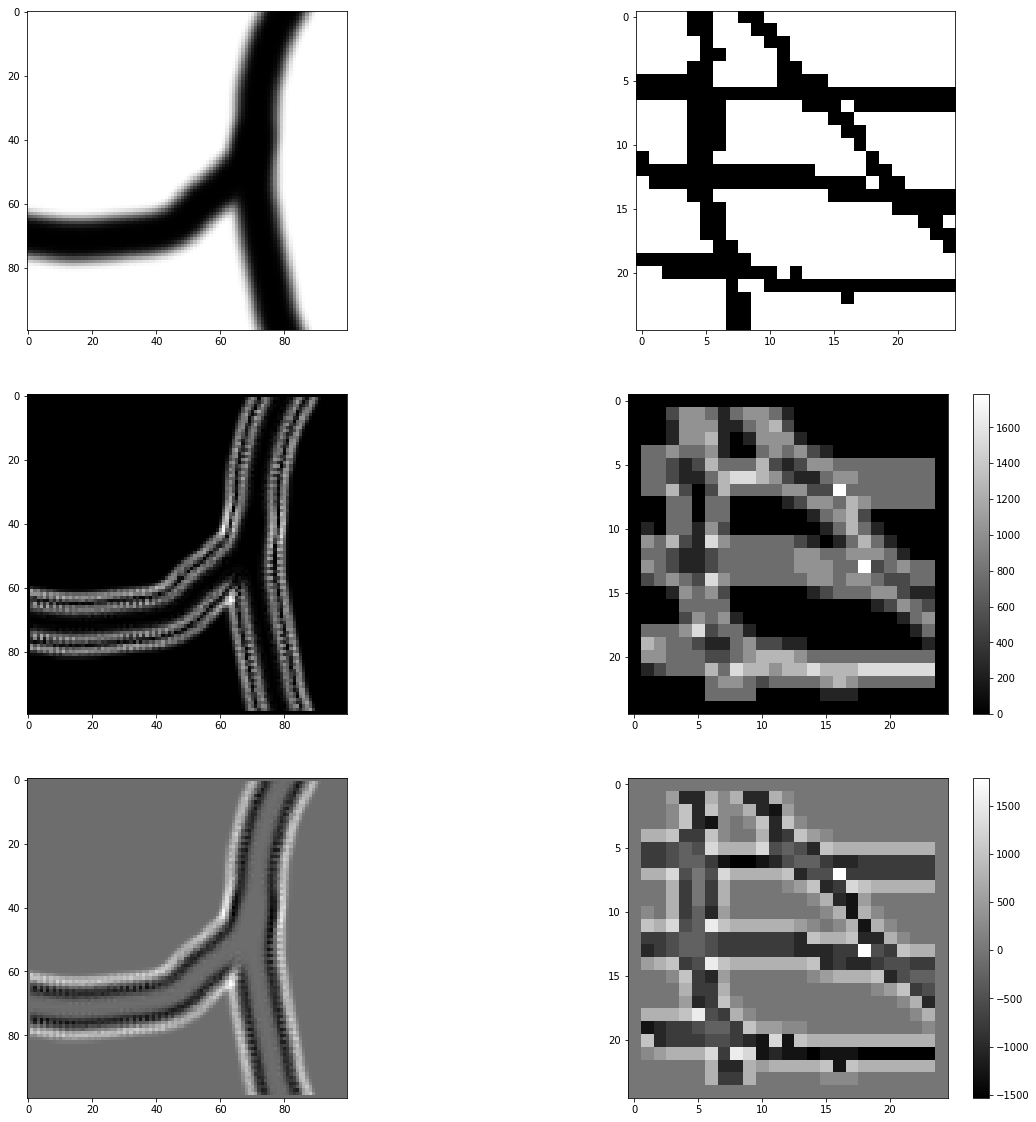

In [110]:
custom = cv2.imread("gradienttest.png",2)
grad,avg = getImgGrad(custom)
grad2,avg2 = getImgGrad(tfbtf)

plt.figure(figsize=[20,20])
plt.subplot(321)
plt.imshow(custom, cmap = 'gray')
plt.subplot(322)
plt.imshow(tfbtf, cmap = 'gray')
plt.subplot(323)
plt.imshow(abs(avg), cmap = 'gray')
plt.subplot(324)
plt.imshow(abs(avg2), cmap = 'gray')
cbar = plt.colorbar()
plt.draw()
plt.subplot(325)
plt.imshow(avg, cmap = 'gray')
plt.subplot(326)
plt.imshow(avg2, cmap = 'gray')
cbar = plt.colorbar()
plt.draw()

In [38]:
# plt.figure(figsize=[12,12])
# plt.subplot(321)
# plt.title('original')
# plt.imshow(custom, cmap = 'gray')
# plt.subplot(322)
# plt.title('original')
# plt.imshow(tfbtf, cmap = 'gray')
# cbar = plt.colorbar()
# plt.draw()

# plt.subplot(323)
# plt.title('o - abs')
# plt.imshow(custom-abs(avg), cmap = 'gray')
# plt.subplot(324)
# plt.title('o - abs')
# plt.imshow(tfbtf-abs(avg2), cmap = 'gray')
# cbar = plt.colorbar()
# plt.draw()

# plt.subplot(325)
# plt.title('o - full range')
# plt.imshow(custom-avg, cmap = 'gray')
# plt.subplot(326)
# plt.title('o - full range')
# plt.imshow(tfbtf-avg2, cmap = 'gray')
# cbar = plt.colorbar()
# plt.draw()

In [39]:
avgGradNoSeam = x for x in avgGrad if x < 0

SyntaxError: invalid syntax (<ipython-input-39-32814b1b5031>, line 1)

In [111]:
def getPos(img):
    copy = np.zeros(img.shape)
    rows = img.shape[0]
    cols = img.shape[1]
    for r in range(0,img.shape[0]):
        for c in range(0,img.shape[1]):
            #now we are iterating through all row-combo pairs.
            #print(getPixGrad(img,r,c))
            if img[r,c] < 0:
                #copy[r,c] = img[r,c]
                copy[r,c] = 255
            else:
                copy[r,c] = 0
    return copy

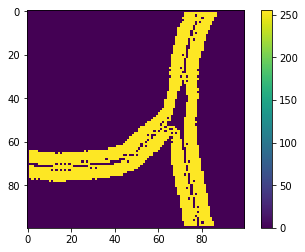

In [112]:
fullGrad, avgGrad = getImgGrad(custom)
#print(avgGrad[0,0])
#avgGrad.shape
plt.imshow(getPos(avgGrad))
cbar = plt.colorbar()

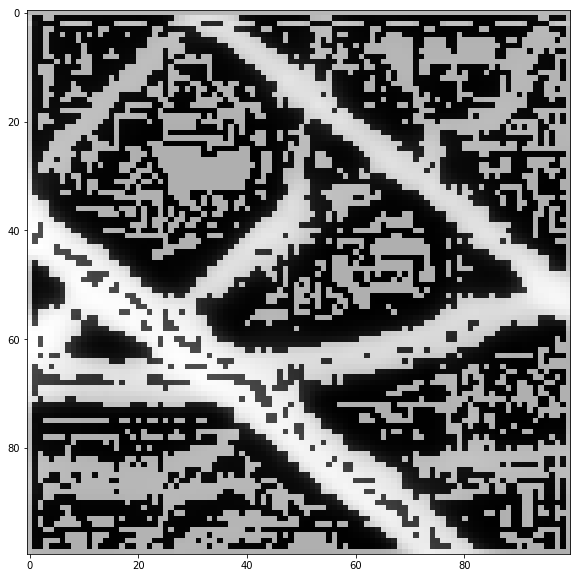

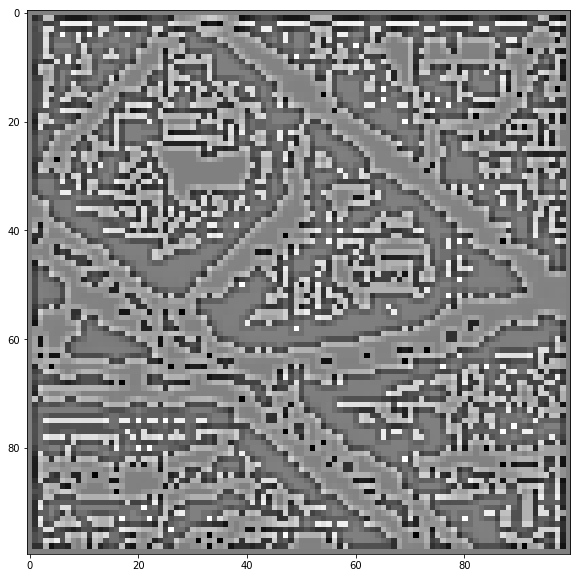

In [113]:
num=100
prevStep = fibers[0:num,0:num]
fullGrad, avgGrad = getImgGrad(prevStep)
difFromPrev = prevStep-getPos(avgGrad)
for i in range(0,1):
    prevStep = difFromPrev
    fullGrad, avgGrad = getImgGrad(prevStep)
    difFromPrev = prevStep-getPos(avgGrad)
plt.figure(figsize=[10,10])
plt.imshow(difFromPrev,cmap='gray')
plt.figure(figsize=[10,10])
plt.imshow(avgGrad,cmap='gray')

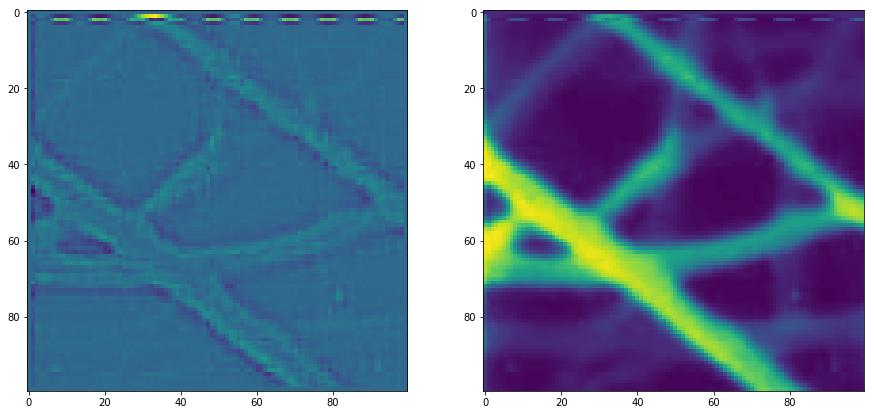

In [114]:
num = 100
fGrad, agrad = getImgGrad(fibers[0:num,0:num])

plt.figure(figsize=[15,15])
plt.subplot(121)
plt.imshow(agrad)
plt.subplot(122)
plt.imshow(fibers[0:num,0:num])

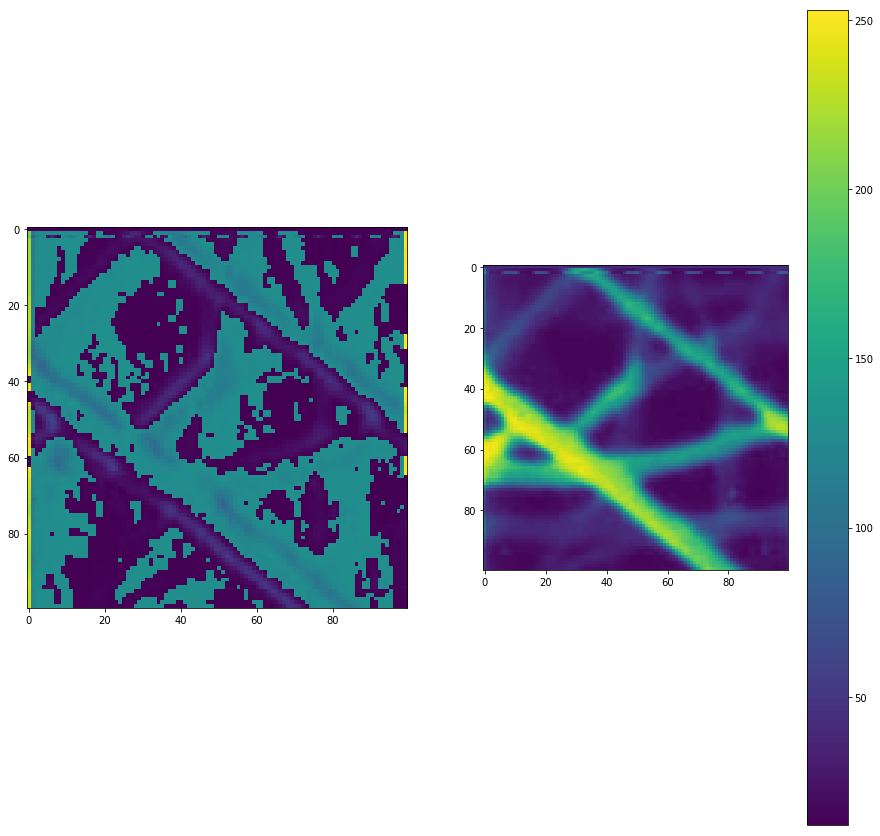

In [115]:
num=100
vgrad = np.gradient(fibers[0:num,0:num])
vt = fibers[0:num,0:num]
mag2 = np.sqrt(vt[0]**2 + vt[1]**2)
mag = np.sqrt(vgrad[0]**2 + vgrad[1]**2)

plt.figure(figsize=[15,15])
plt.subplot(1,2,1),plt.imshow(vgrad[1])
plt.subplot(1,2,2),plt.imshow(vt)
plt.colorbar()

In [117]:
fGrad, aGrad = getImgGrad(custom)
#x = np.empty(shape=(1,100))
#y = np.ndarray(shape=(custom.shape[0],1))
#x[0] = 10
x = np.zeros(custom.shape)
y = np.zeros(custom.shape)
for r in range(0,custom.shape[0]):
        for c in range(0,custom.shape[1]):
            x[r,c] = fGrad[r,c][0,0]*(-np.sqrt(2)/2) + fGrad[r,c][0,2]*(np.sqrt(2)/2) + fGrad[r,c][1,0]*(-1) + fGrad[r,c][1,2]*(1) + fGrad[r,c][2,0]*(-np.sqrt(2)/2) + fGrad[r,c][2,2]*(np.sqrt(2)/2)
            y[r,c] = fGrad[r,c][0,0]*(np.sqrt(2)/2) + fGrad[r,c][0,1]*(1) + fGrad[r,c][0,2]*(-np.sqrt(2)/2) + fGrad[r,c][2,0]*(-np.sqrt(2)/2) + fGrad[r,c][2,1]*(-1) + fGrad[r,c][2,2]*(-np.sqrt(2)/2)
            #print(fGrad[r,c][0,0])
print(x.shape)

theta = np.zeros(x.shape)
for r in range(0,x.shape[0]):
    for c in range(0,x.shape[1]):
        if x[r,c] != 0:
            theta[r,c] = np.arctan(y[r,c]/x[r,c])*180 / np.pi
        else:
            theta[r,c] = 0

(100, 100)


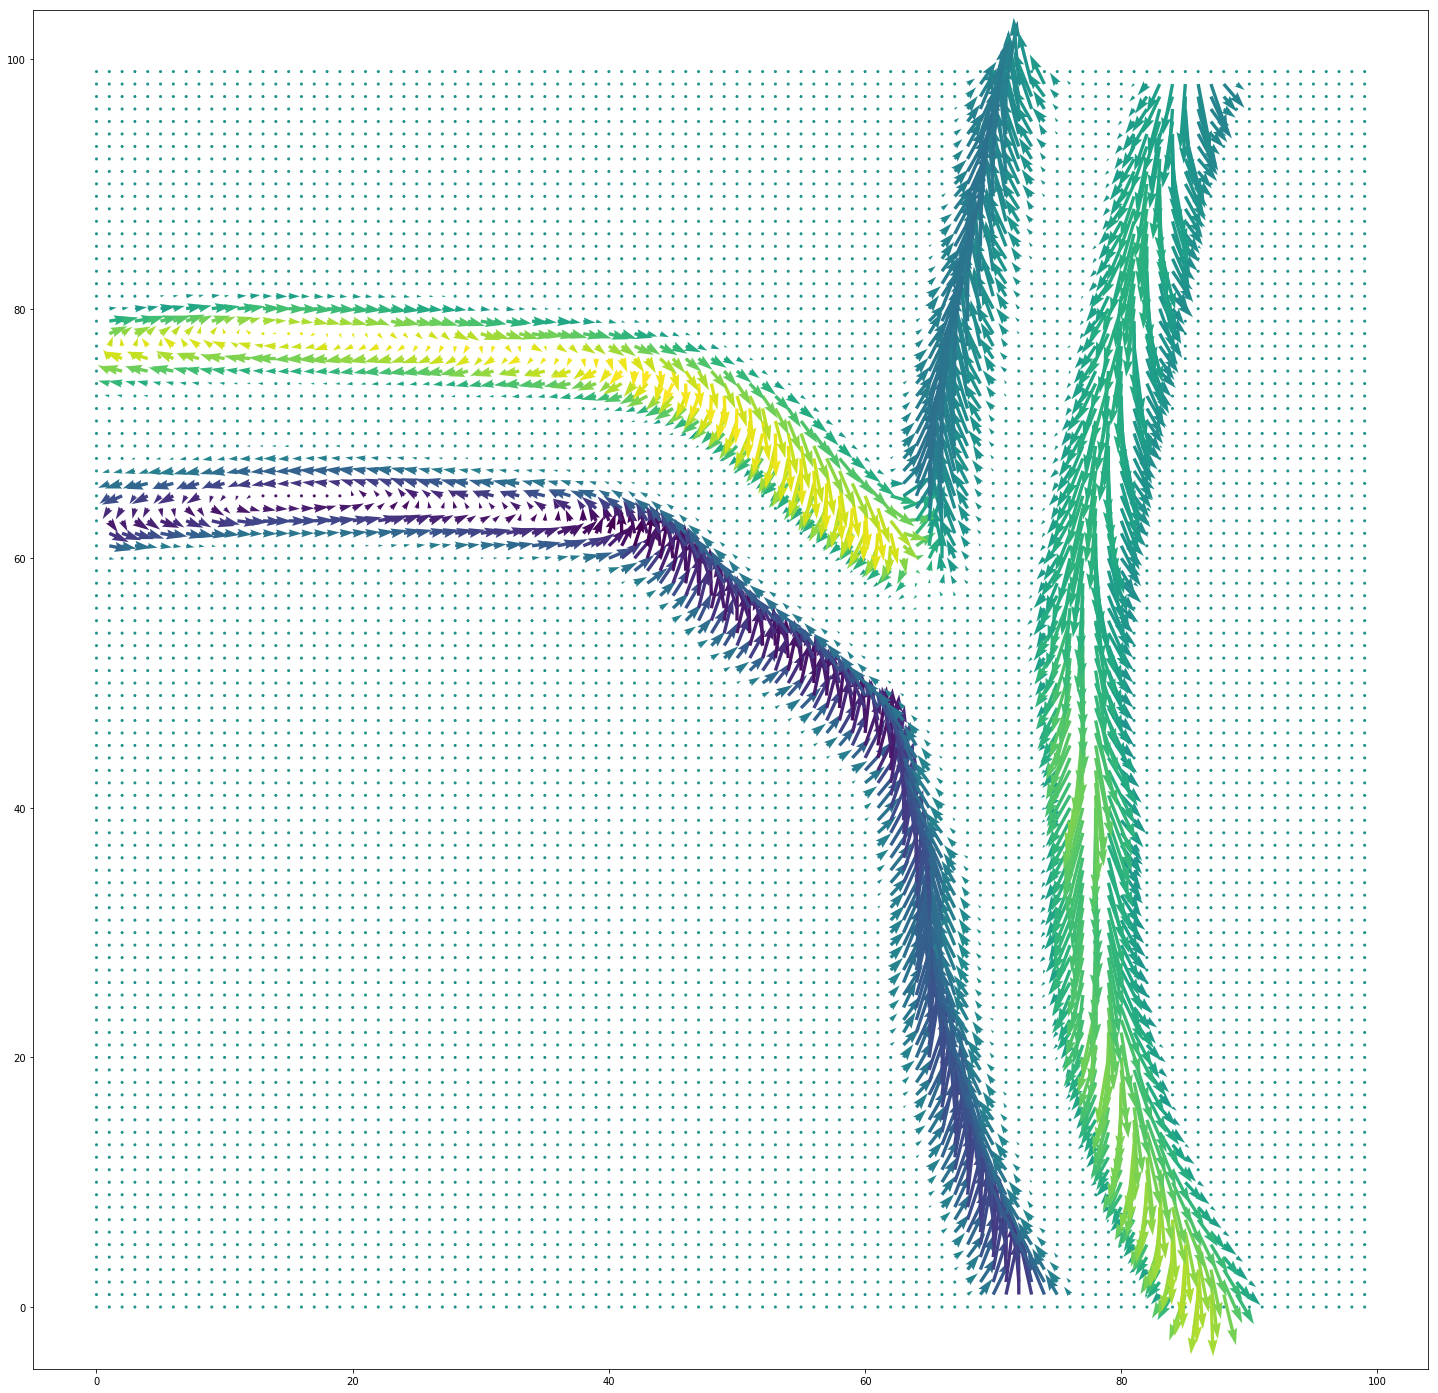

In [118]:
plt.figure(figsize=[25,25])
plt.quiver(aGrad,x,y)

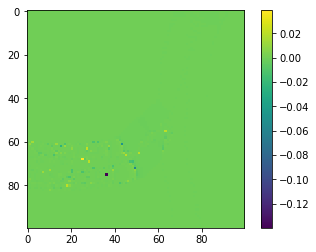

In [42]:
plt.imshow(theta*np.pi / 180.)
plt.colorbar()

# Zhang Algorithm Definition

In [24]:
#Lookup arrays
table1 = [0,0,0,0,0,0,1,3,0,0,3,1,1,0,1,3,0,0,0,0,0,0,0,0,0,0,2,0,3,0,3,3,
0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,3,0,2,2,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
2,0,0,0,0,0,0,0,2,0,0,0,2,0,0,0,3,0,0,0,0,0,0,0,3,0,0,0,3,0,2,0,
0,0,3,1,0,0,1,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
2,3,1,3,0,0,1,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
2,3,0,1,0,0,0,1,0,0,0,0,0,0,0,0,3,3,0,1,0,0,0,0,2,2,0,0,2,0,0,0]
table2 = [0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,2,2,0,0,0,0,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

In [25]:
def thinZhang(image,passnum,table):
    nrows = image.shape[0] #number of rows in the image
    ncols = image.shape[1] #number of columns in the image

    p1 = 0
    p2 = 0
    p3 = 0
    p4 = 0
    p5 = 0
    p6 = 0
    p7 = 0
    p8 = 0
    p9 = 0
    bgColor = 255
    v = 0
    index = 0
    code = 0
    pixelsRemoved=0
    
    
    for row in range(nrows-2): #outside loop should be over the number of rows in the image
        for col in range(ncols-2): #inside loop over columns
            p5 = image[row+1,col+1]
            v = p5
            if(v != bgColor):
                p1 = image[row,col]
                p2 = image[row,col+1]
                p3 = image[row,col+2]
                p4 = image[row+1,col-1]
                p6 = image[row+1,col+1]
                p7 = image[row+2,col-1]
                p8 = image[row+2,col]
                p9 = image[row+2,col+1]
                index = 0;
                if (p1!=bgColor): index += 1;
                if (p2!=bgColor): index += 2;
                if (p3!=bgColor): index += 4;
                if (p6!=bgColor): index += 8;
                if (p9!=bgColor): index += 16;
                if (p8!=bgColor): index += 32;
                if (p7!=bgColor): index += 64;
                if (p4!=bgColor): index += 128;
                code = table[index]
                if(passnum%2 == 0):
                    if(code == 1 or code == 3):
                        v = bgColor
                        pixelsRemoved+=1
                else:
                    if(code == 2 or code == 3):
                        v = bgColor
                        pixelsRemoved+=1
                image[row+1,col+1] = v
       # index = 0
        #code = 0
    return pixelsRemoved

In [26]:
def skeletonize(image):
    passnum = 0
    pixelsRemoved=0
    while(pixelsRemoved == 0):
        pixelsRemoved = thinZhang(image,passnum,table1)
        passnum+=1
        pixelsRemoved += thinZhang(image,passnum,table1)
    pixelsRemoved = 0
    while(pixelsRemoved == 0):
        pixelsRemoved = thinZhang(image,passnum,table2)
        passnum+=1
        pixelsRemoved += thinZhang(image,passnum,table2)

In [ ]:
tfbtf = cv2.imread("tfbtf.png",2)

plt.figure(figsize=[20,10])
plt.imshow(tfbtf,cmap='gray')
print(tfbtf.shape)

In [ ]:
skeletonize(tfbtf)

In [ ]:
plt.figure(figsize=[20,10])
plt.imshow(tfbtf,cmap='gray')
print(tfbtf.shape)

In [37]:
statsarray = [3.536,2.544,2.774,1.833,2.734,2.749,1.803,3.167,2.506,2.242,2.267,2.603,2.759]
print(np.average(statsarray))
print(np.std(statsarray))

2.5782307692307693
0.4609079924613945


In [35]:
statsarray = [4.243
,3.496
,2.654
,3.680
,3.095
,2.645
,2.565
,3.024
,2.563
,2.299
,2.250
,2.791
,2.931
]
print(np.average(statsarray))
print(np.std(statsarray))

2.9412307692307684
0.5509742635126024


In [36]:
statsarray = [2.828
,2.386
,2.602
,3.060
,3.282
,2.625
,2.669
,3.024
,2.959
,3.496
,2.563
,2.580
,2.957
]
print(np.average(statsarray))
print(np.std(statsarray))

2.8485384615384612
0.30603635163279225


In [38]:
statsarray = [2.828,
2.370,
2.374,
2.630,
2.865,
2.823,
2.964,
3.305,
2.366,
2.788,
2.912,
2.998,
3.313
]
print(np.average(statsarray))
print(np.std(statsarray))

2.8104615384615386
0.3018824568461693


In [39]:
statsarray = [2.828,
3.555,
2.434,
2.495,
2.434,
2.513,
2.760,
2.587,
2.368,
2.931,
2.783,
3.070,
2.337]
print(np.average(statsarray))
print(np.std(statsarray))

2.699615384615385
0.33066658514664643


In [72]:
print(np.average([3.4,2.8,3.6,2.7]))

3.125


In [ ]:
3.3 pm 0.1
1.9 pm 0.04
2.2 pm 0.09
2.9 pm 0.04
3.2 pm 0.3
1.8 pm 0.07
0.9 pm 0.08

In [73]:
print(np.sqrt((0.5)**2+(0.9)**2+(1.2)**2+(1.5)**2))

2.179449471770337


In [ ]:
22
0 - 187
0 - 54

In [ ]:
3.4279488511318124

2.8043729868748777

3.6668060035851417

2.722943170245202

In [ ]:
49 0.5374469403640052
49 0.9185997408119669
49 1.1863991703179932
49 1.5300771376537088